In [161]:
using Plots
using LaTeXStrings
using Colors, ColorSchemes
using Printf
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));

using DelimitedFiles

const e_charge = 1.60217663E-19; 
const r_e = 2.8179402895E-15;
const mec2 = 510998.94999999995;

# Lattice Parameters

In [162]:
rho = 1.5
gamma = 10000.0
phi_m = 0.2

beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

#sigma_z = 50e-6
#sigma_x = 50e-6

p0c = gamma * beta * mec2;

#L0 = (24*sigma_z*rho^2)^(1/3)

# Beam Initialization

In [163]:
using Distributions, Random

# Fake Gaussian beam

Np = 5000000   # Number of macro-particles
Q = 5E-9       # Total charge in C

charges = ones(Np)*Q/Np;

bb = Array{Float64, 2}(undef, 6, Np);
Random.seed!(1234)

bb[1,1:Np] = rand(Normal(0, 50E-6), Np);
bb[2,1:Np] = rand(Normal(0, 50E-6), Np);
bb[3,1:Np] = rand(Normal(0, 50E-6), Np);
bb[4,1:Np] = rand(Normal(0, 50E-6), Np);
bb[5,1:Np] = rand(Normal(0, 50E-6), Np);
bb[6,1:Np] = rand(Normal(0, 1E-6), Np);

zmin = minimum(bb[5,:])
zmax = maximum(bb[5,:])
xmin = minimum(bb[1,:])
xmax = maximum(bb[1,:])

0.00026359569535430965

In [164]:
include("../core/kick2.jl")

csr2d_kick_calc_exit (generic function with 1 method)

In [165]:
z_b = bb[5,:]
x_b = bb[1,:]

# Size of the distribution grid
nz_cg=200
nx_cg=100

dz_cg = (zmax - zmin) / (nz_cg - 1)
dx_cg = (xmax - xmin) / (nx_cg - 1)

# Charge deposition
println(" Applying charge deposition...")
charge_grid = histogram_cic_2d(z_b, x_b, charges, nz_cg, zmin, zmax, nx_cg, xmin, xmax)
    
# Normalize charge grid
nn = sum(charge_grid) *dz_cg*dx_cg
lambda_grid = charge_grid ./ nn;


 Applying charge deposition...


### Check entrance wake convergence with $nxp$ and $M$

In [166]:
phi = 0.01

function entrance_wake_conv_test(nxp, M)
    wA = compute_wake_case_A(0.0, 0.0, 
            gamma=gamma, rho=rho, phi=phi, nxp=nxp, M=M,
            lambda_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)
        
    wB = compute_wake_case_B(0.0, 0.0, 
            gamma=gamma, rho=rho, phi=phi, nxp=nxp, M=M,
            lambda_grid=lambda_grid, zmin=zmin, zmax=zmax, xmin=xmin, xmax=xmax, dimension=1)
        
    return wA + wB
end

entrance_wake_conv_test (generic function with 1 method)

In [167]:
using StatProfilerHTML
#Profile.clear()
@profilehtml entrance_wake_conv_test(10000, 6)

[ Info: Wrote profiling output to file:///Users/mpe/code/JuliaCSR2D/examples/statprof/index.html .


12404.466762330849

In [45]:
#f200(M) = entrance_wake_conv_test(200, M)
#f250(M) = entrance_wake_conv_test(250, M)
f300(M) = entrance_wake_conv_test(300, M)
f350(M) = entrance_wake_conv_test(350, M)
f400(M) = entrance_wake_conv_test(400, M)
f500(M) = entrance_wake_conv_test(500, M)
#f600(M) = entrance_wake_conv_test(600, M)
#f700(M) = entrance_wake_conv_test(700, M)
#f800(M) = entrance_wake_conv_test(800, M)
#f900(M) = entrance_wake_conv_test(900, M)
f1000(M) = entrance_wake_conv_test(1000, M)

f1000 (generic function with 1 method)

In [20]:
phi = 0.01
M_vec = 3:10

#W00_nxp_200 = map(f200, M_vec);
#W00_nxp_250 = map(f250, M_vec);
@time W00_nxp_300 = map(f300, M_vec);
#W00_nxp_350 = map(f350, M_vec);
#W00_nxp_400 = map(f400, M_vec);
#W00_nxp_500 = map(f500, M_vec);
#W00_nxp_600 = map(f600, M_vec);
#W00_nxp_700 = map(f700, M_vec);
#W00_nxp_800 = map(f800, M_vec);
#W00_nxp_900 = map(f900, M_vec);
@time W00_nxp_1000 = map(f1000, M_vec);

  5.508959 seconds (440.34 k allocations: 334.620 MiB, 0.64% gc time)
 18.217129 seconds (1.47 M allocations: 1.090 GiB, 0.75% gc time)


In [30]:
W00_ref = W00_nxp_1000[8]

ix1=4
ix2=8

plot(M_vec[ix1:ix2], abs.((W00_nxp_300[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 300", linewidth=3, color="green")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_350[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 350", linewidth=3, color="blue")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_400[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 400", linewidth=3, color="brown")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_500[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 500", linewidth=3, color="purple")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_1000[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 1000", linewidth=3, color="red")


plot!(title="Convergence test for entrance wake \n"*L" $Ws(0,0)$ at $\phi = 0.01$")
plot!(xlabel=L"$M$ (unitless)", ylabel=L"|% error| in $Ws(0,0)$")
plot!(xtickfont=font(14), ytickfont=font(14), guidefont=font(15), margin=1Plots.mm, legend=(0.65, 0.80), legendfontsize = 16)

LoadError: UndefVarError: W00_nxp_350 not defined

In [11]:
phi = 0.05
M_vec = 3:10

W00_nxp_300 = map(f300, M_vec);
W00_nxp_350 = map(f350, M_vec);
W00_nxp_400 = map(f400, M_vec);
W00_nxp_500 = map(f500, M_vec);

W00_nxp_1000 = map(f1000, M_vec);

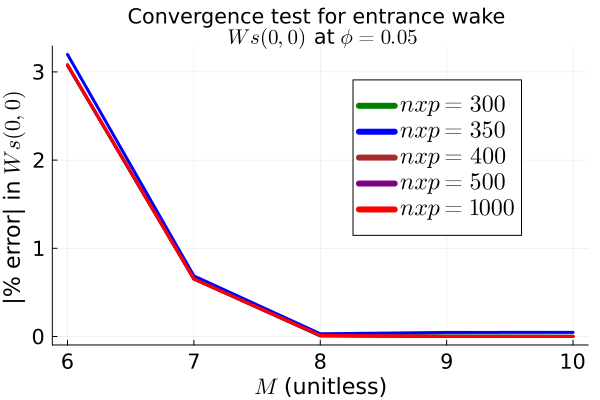

In [12]:
W00_ref = W00_nxp_1000[8]

ix1=4
ix2=8

plot(M_vec[ix1:ix2], abs.((W00_nxp_300[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 300", linewidth=3, color="green")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_350[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 350", linewidth=3, color="blue")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_400[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 400", linewidth=3, color="brown")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_500[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 500", linewidth=3, color="purple")
plot!(M_vec[ix1:ix2], abs.((W00_nxp_1000[ix1:ix2].-W00_ref)./W00_ref.*100), label=L"nxp = 1000", linewidth=3, color="red")

plot!(title="Convergence test for entrance wake \n"*L" $Ws(0,0)$ at $\phi = 0.05$")
plot!(xlabel=L"$M$ (unitless)", ylabel=L"|% error| in $Ws(0,0)$")
plot!(xtickfont=font(14), ytickfont=font(14), guidefont=font(15), margin=1Plots.mm, legend=(0.65, 0.80), legendfontsize = 16)

In [119]:
asinh(2/pi*atanh(1-eps(Float64)))

3.154019550531224

In [118]:
eps(Float64)

2.220446049250313e-16